# Classification
**Objective**: Predict if an earthquake causes a tsunami

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## Data Loading

In [2]:
df = pd.read_csv('../data/earthquake_data_tsunami.csv')

## Splitting Data

In [3]:
X = df.drop(columns=['tsunami','Month','Year'], axis=1) # Features
y = df['tsunami'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((625, 10), (157, 10))

## Preprocessing

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## LazyPredict Benchmark

In [9]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Best 2 models")
print(models.head(10))

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 243, number of negative: 382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 625, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388800 -> initscore=-0.452359
[LightGBM] [Info] Start training from score -0.452359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## Hyperparameters Tuning (Top 2 model + SVC, KNN, BaggingClassifier)

  0%|          | 0/5 [00:00<?, ?it/s]

Model: SVC
Best params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.7895939037299957


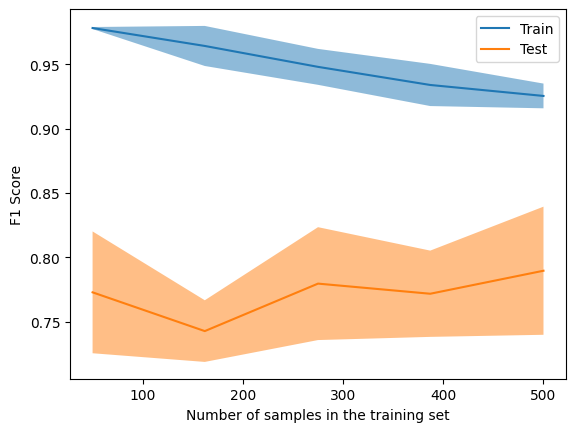

 20%|██        | 1/5 [00:15<01:01, 15.35s/it]

Model: RandomForestClassifier
Best params {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score 0.8741916389974642


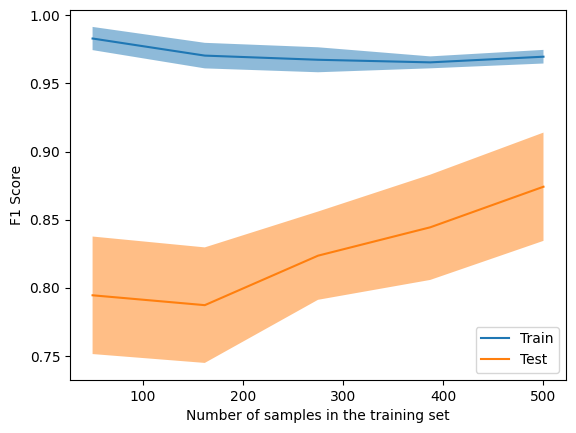

 40%|████      | 2/5 [00:45<01:11, 23.79s/it]

Model: KNeighborsClassifier
Best params {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best score 0.8179920200260005


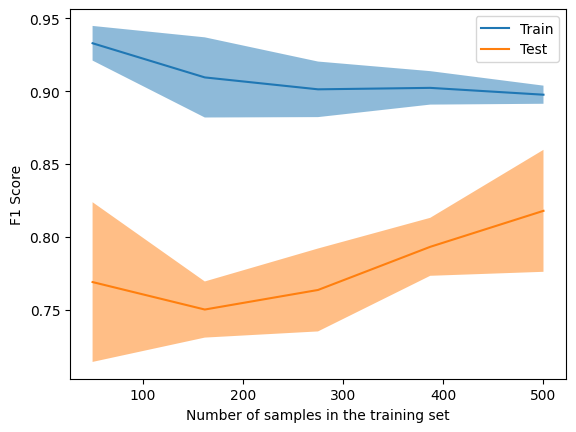

 60%|██████    | 3/5 [00:45<00:26, 13.22s/it]

Model: AdaBoostClassifier
Best params {'learning_rate': 1.0, 'n_estimators': 200}
Best score 0.8539900961119175


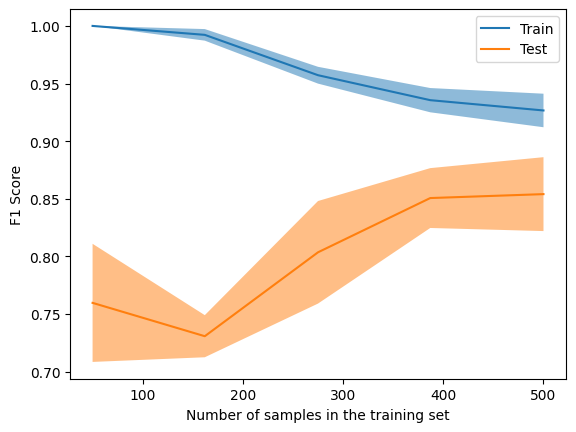

 80%|████████  | 4/5 [00:52<00:10, 10.73s/it]

Model: BaggingClassifier
Best params {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best score 0.8604452727122904


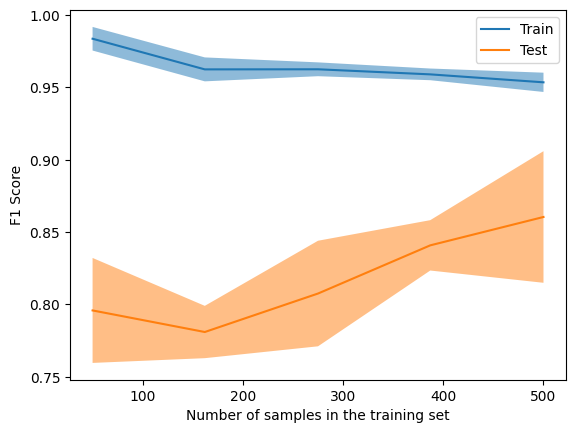

100%|██████████| 5/5 [00:56<00:00, 11.35s/it]


In [ ]:
models = {
    'SVC': SVC(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(random_state=42),
}


params_grid = {
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 15, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0]
    },
    'BaggingClassifier': {
        'n_estimators': [10, 20, 50],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    }
}

training_results = {}

for model_key, model in tqdm(models.items()):

    grid = GridSearchCV(
        estimator=model,
        param_grid=params_grid[model_key],
        scoring='f1',
        cv=5,
        n_jobs=-1,
    )

    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    f1 = f1_score(y_test, y_pred)

    training_results[model_key] = {
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'test_f1': f1,
        'model': best_model
    }

    print(f"Model: {model_key}")
    print(f"Best params {grid.best_params_}")
    print(f"Best score {grid.best_score_}")

    train_sizes, train_scores, test_scores = learning_curve(
        best_model,
        X_train_scaled,
        y_train,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        random_state=42
    )

    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores,
        test_scores=test_scores,
        score_name="F1 Score",
    )
    display.plot()
    plt.show()

## Model Comparison


Model Comparison:
                    Model  CV F1 Score  Test F1 Score
1  RandomForestClassifier         0.87           0.88
4       BaggingClassifier         0.86           0.86
3      AdaBoostClassifier         0.85           0.85
2    KNeighborsClassifier         0.82           0.85
0                     SVC         0.79           0.82


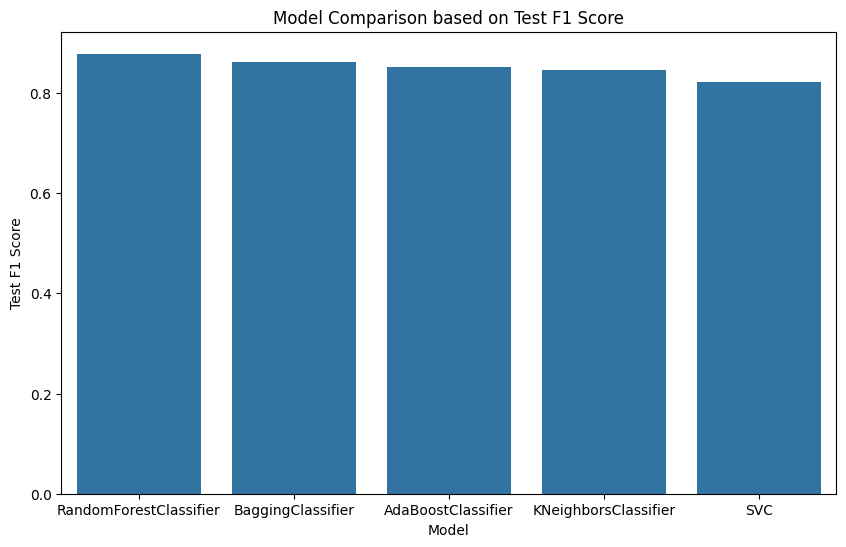

In [16]:
comparison = pd.DataFrame([
    {
        'Model': model,
        'CV F1 Score': results['cv_f1'],
        'Test F1 Score': results['test_f1']
    }
    for model, results in training_results.items()
])

comparison = comparison.sort_values(by='Test F1 Score', ascending=False)
print("\nModel Comparison:")
print(comparison)


plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Test F1 Score', data=comparison)
plt.title('Model Comparison based on Test F1 Score')
plt.ylabel('Test F1 Score')
plt.yscale('linear')
plt.show()

## Best Model Evaluation

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        96
           1       0.87      0.89      0.88        61

    accuracy                           0.90       157
   macro avg       0.90      0.90      0.90       157
weighted avg       0.90      0.90      0.90       157



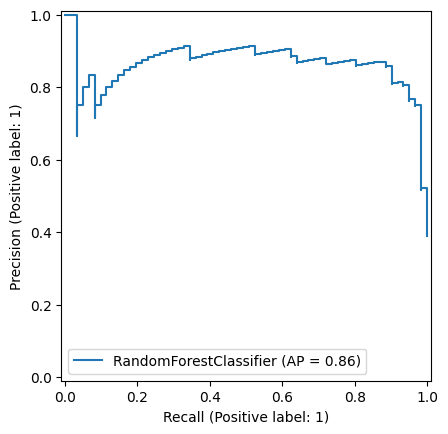

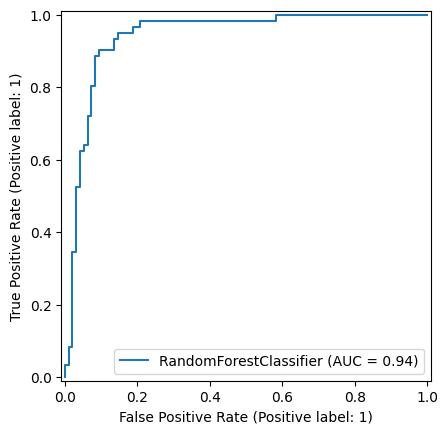

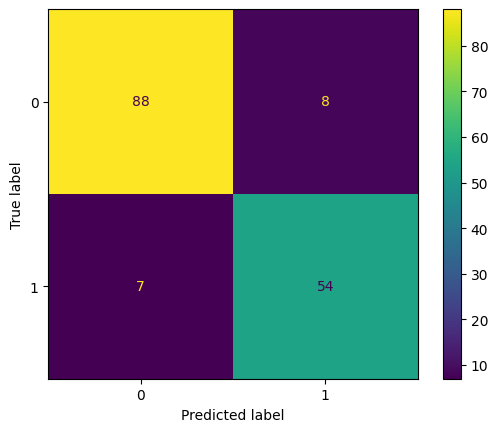

In [17]:
best_model_name = comparison.iloc[0]['Model']
best_model = training_results[best_model_name]["model"]

y_pred_best = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_best))

PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()
